## CASE 1: Linear perturbation with gravity for $\lambda = 1.11 \lambda_{\rm J}$

In [19]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np
import os

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Concatenate, Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Lambda
import matplotlib.pyplot as plt
import scipy
# plt.style.use('ggplot')
## Setting the backend to Tensorflow
dde_backend = tf

## For the FFT solver

from numpy.fft import fft, ifft
from scipy import signal

np.random.seed(1234)
tf.random.set_seed(1234)

In [20]:
#Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
#%matplotlib inline

lam = 7.0           # one wavelength
num_of_wave = 3     # the number of waves
cs = 1.0            # % Sound Speed 
rho_1 = 0.03;       # question 2b non-linear wave propagation
rho_o = 1.0         # zeroth order density
const = 1           # 4.0 * np.pi  # The actual value is 4*pi
G = 1               # Gravitational Constant

jeans = np.sqrt(4*np.pi**2*cs**2/(const*G*rho_o))
if lam> jeans:
    alpha = np.sqrt(const*G*rho_o-cs**2*(2*np.pi/lam)**2)
else:
    alpha = np.sqrt(cs**2*(2*np.pi/lam)**2 - const*G*rho_o)
    
# v_1 = (cs*rho_1)/rho_o # velocity perturbation without gravity
v_1  = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) ## With gravity

tmax= 3

## For comparison in 1D when plotting
ycut=zcut=0.5

output_folder = "3D_fig_" + str(lam) + '_' + str(tmax) + '_' + str(num_of_wave) +  '_' + str(rho_1)

try:
    os.makedirs(output_folder)
except OSError:
    print ("Creation of the directory %s failed/ not needed as it already exit" % output_folder)
else:
    print ("Successfully created the directory %s" % output_folder)

Creation of the directory 3D_fig_7.0_3_3_0.03 failed/ not needed as it already exit


### Network hyperparameters

In [21]:
## General Network Parameters

learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 32 ## 100
activation = "sin" #"tanh"

iterations_adam = 2000

# collocation_points 
precision_train = 300 #200 ## collocation points density
hx_train = lam/ precision_train
nx_train = int(1 / hx_train)*num_of_wave
print("The number of collocation points resolving the domain are = {} and at boundaries are = {}".format(nx_train*nx_train*tmax,50*nx_train))


The number of collocation points resolving the domain are = 47628 and at boundaries are = 6300


## PINN Architecture

Compiling model...
Building feed-forward neural network...


/home/sauddy3/PINNS-envcedar/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.807909 s



2023-07-12 13:20:40.685755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 27631 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


wavelength 7.0
wavelength 7.0
'compile' took 4.979300 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                                                                                                                        Test loss                                                                                                                                                                                                                                                                         Test metric
0         [3.04e-02, 1.38e-02, 2.21e-02, 1.72e-02, 9.18e-01, 4.99e-01, 1.13e-02, 1.80e-02, 7.24e-03, 1.07e-02, 6.32e-03, 5.39e-02, 9.43e-03, 1.94e-03, 4.16e-01, 7.26e-03, 1.83e-02, 1.87e-01, 4.11e-03, 3.79e-01, 1.88e-03, 3.93e-02, 2.31e-03, 1.10e+00, 2.02e-02, 6.86e-02, 5.45e-02]    [3.04e-02, 1.38e-02, 2.21e-02, 1.72e-02, 9.1

2023-07-12 13:21:01.957049: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion_51'



1000      [1.23e-04, 9.62e-05, 8.80e-05, 6.76e-05, 1.20e-04, 1.41e-05, 5.18e-05, 6.43e-05, 9.76e-06, 3.19e-05, 3.65e-05, 1.05e-05, 4.76e-05, 2.52e-05, 8.00e-06, 1.60e-05, 2.50e-05, 1.90e-06, 2.93e-05, 2.13e-05, 2.86e-05, 1.54e-05, 2.08e-05, 8.11e-05, 3.83e-05, 2.39e-05, 1.13e-05]    [1.23e-04, 9.62e-05, 8.80e-05, 6.76e-05, 1.20e-04, 1.41e-05, 5.18e-05, 6.43e-05, 9.76e-06, 3.19e-05, 3.65e-05, 1.05e-05, 4.76e-05, 2.52e-05, 8.00e-06, 1.60e-05, 2.50e-05, 1.90e-06, 2.93e-05, 2.13e-05, 2.86e-05, 1.54e-05, 2.08e-05, 8.11e-05, 3.83e-05, 2.39e-05, 1.13e-05]    []  
2000      [4.49e-05, 2.10e-05, 2.62e-05, 2.09e-05, 3.58e-05, 3.18e-06, 1.69e-05, 1.48e-05, 2.85e-06, 9.54e-06, 1.07e-05, 4.07e-06, 1.99e-05, 8.46e-06, 4.08e-06, 9.07e-06, 6.50e-06, 1.61e-06, 1.39e-05, 6.10e-06, 8.17e-06, 5.59e-06, 9.33e-06, 1.65e-05, 1.92e-05, 1.06e-05, 3.78e-06]    [4.49e-05, 2.10e-05, 2.62e-05, 2.09e-05, 3.58e-05, 3.18e-06, 1.69e-05, 1.48e-05, 2.85e-06, 9.54e-06, 1.07e-05, 4.07e-06, 1.99e-05, 8.46e-06, 4.08e-06, 9.

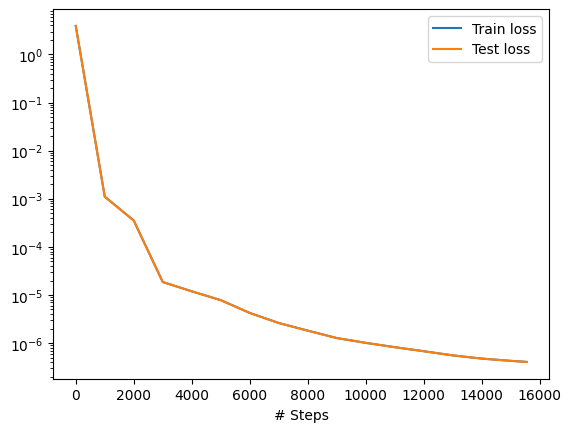

In [22]:
def pdeg(x, y):   

    '''
    The first argument to pde is a 2-dimensional vector where the first component(x[:,0]) is 𝑥
    -coordinate and the second componenet (x[:,1]) is the 𝑡-coordinate.

    The second argument is the network output,is 3-dimensional vector where the first component
    (y[:,0]) is density and the second componenet (y[:,1]) is the velocity amd the third component  (y[:,2])is 
    the gravity in the x direction
    '''
    cs = 1. ## Is the sound speed

    rho, vx, vy,vz, phi= y[:,0:1],y[:,1:2],y[:,2:3],y[:,3:4],y[:,4:5]
    
    rho_t = dde.grad.jacobian(y, x, i=0, j=3)
    rho_x = dde.grad.jacobian(y, x, i=0, j=0)
    rho_y = dde.grad.jacobian(y, x, i=0, j=1)
    rho_z = dde.grad.jacobian(y, x, i=0, j=2)

    vx_t = dde.grad.jacobian(y, x, i=1, j=3)
    vy_t = dde.grad.jacobian(y, x, i=2, j=3)
    vz_t = dde.grad.jacobian(y, x, i=3, j=3)
    
    vx_x = dde.grad.jacobian(y, x, i=1, j=0)
    vy_y = dde.grad.jacobian(y, x, i=2, j=1)
    vz_z = dde.grad.jacobian(y, x, i=3, j=2)
    
    vx_y = dde.grad.jacobian(y, x, i=1, j=1)
    vx_z = dde.grad.jacobian(y, x, i=1, j=2)
    
    vy_x = dde.grad.jacobian(y, x, i=2, j=0)    
    vy_z = dde.grad.jacobian(y, x, i=2, j=2)
    
    vz_x = dde.grad.jacobian(y, x, i=3, j=0)
    vz_y = dde.grad.jacobian(y, x, i=3, j=1)
    
   
    phi_x = dde.grad.jacobian(y, x, i=4, j=0)
    phi_xx= dde.grad.hessian(y, x, component=4, i=0, j=0)
    
    phi_y = dde.grad.jacobian(y, x, i=4, j=1)
    phi_yy= dde.grad.hessian(y, x, component=4, i=1, j=1)
    
    phi_z = dde.grad.jacobian(y, x, i=4, j=2)
    phi_zz= dde.grad.hessian(y, x, component=4, i=2, j=2)
    
    

    
    rho_r = rho_t + vx * rho_x + rho * vx_x + vy *rho_y + rho * vy_y + vz *rho_z +rho * vz_z  ## The residue from the density equation

    # vx_r = rho*vx_t + rho*vx*vx_x + cs*cs*rho_x +rho*phi_x  ### THe momentum equation in 1D- in X
    # vy_r = rho*vy_t + rho*vy*vy_y + cs*cs*rho_y +rho*phi_y  ### THe momentum equation in 1D- in Y
#     
    vx_r = rho*vx_t + rho*(vx*vx_x +vy*vx_y+vz*vx_z) + cs*cs*rho_x +rho*phi_x  ### THe momentum equation in 1D- in X
    vy_r = rho*vy_t + rho*(vy*vy_y+ vx*vy_x+vz*vy_z) + cs*cs*rho_y +rho*phi_y  ### THe momentum equation in 1D- in Y
    vz_r = rho*vz_t + rho*(vz*vz_z+ vx*vz_x+vy*vz_y) + cs*cs*rho_y +rho*phi_y  ### THe momentum equation in 1D- in Y

    
    phi_r = phi_xx + phi_yy +phi_zz - const*(rho - rho_o)  ## The residue from the poisson equation
    
   
    return [rho_r,vx_r,vy_r,vz_r,phi_r]

xmin= 0 
xmax= lam*num_of_wave
ymin= 0 
ymax= 1

zmin= 0 
zmax= 1

tmax= tmax

geom = dde.geometry.Cuboid(xmin=[xmin, ymin,zmin], xmax=[xmax, ymax,zmax])
timedomain = dde.geometry.TimeDomain(0, tmax)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# def rho_func(x,y):
#   return y[:,0:1]


# def v_func(x,y):
#   return y[:,1:2]

# def boundary_l(x, on_boundary):
#   return on_boundary and np.isclose(x[0], -1)

def func(x):
    return 0

def boundary(x, on_boundary):
    return on_boundary

## Boundaries

## Note in the deep XDE code by default for the periodic boundary u(0) = u(1)
## If the problem is periodic this condition will also satisfy u(-1) = u(1)
## Thus is most cases the left boundary is not needed. But we have the option here



# def boundary_l(x, on_boundary):  # boundary x=-1 or x = 0 
#     is_on_boundary_left = on_boundary and np.isclose(x[0], xmin)
    
#     return is_on_boundary_left

def boundary_r(x, on_boundary):  # boundary x=1
    is_on_boundary_right = on_boundary and np.isclose(x[0], xmax)
    # print("Collocation {} and x {}".format(x,x[0]))
    # print(is_on_boundary_right)
    return is_on_boundary_right

def boundary_u(x, on_boundary):  # boundary x=1
    is_on_boundary_up = on_boundary and np.isclose(x[1], ymax)
    # is_on_boundary_up =  np.isclose(x[1], ymax)
    # print("Collocation {} and y {}".format(x,x[1]))
    # print(is_on_boundary_up)
    return is_on_boundary_up

def boundary_z(x, on_boundary):  # boundary x=1
    is_on_boundary_z = on_boundary and np.isclose(x[2], zmax)
    # is_on_boundary_up =  np.isclose(x[1], ymax)
    # print("Collocation {} and y {}".format(x,x[1]))
    # print(is_on_boundary_up)
    return is_on_boundary_z


# def boundary_d(x, on_boundary):  # boundary x=1
#     is_on_boundary_lower = on_boundary and np.isclose(x[1], ymin)
#     # print(is_on_boundary_up)
#     return is_on_boundary_lower


## Boundary Conditions
bc_rhox = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0,boundary_r, component=0)
bc_rhoy = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 1, boundary_u, component=0)
bc_rhoz = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 2, boundary_z, component=0)

bc_vxx = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0, boundary_r, component=1)
bc_vxy = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 1, boundary_u, component=1)
bc_vxz = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 2, boundary_z, component=1)

bc_vyx = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0, boundary_r, component=2)
bc_vyy = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 1, boundary_u, component=2)
bc_vyz = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 2, boundary_z, component=2)

bc_vzx = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0, boundary_r, component=3)
bc_vzy = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 1, boundary_u, component=3)
bc_vzz = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 2, boundary_z, component=3)



phixr =  dde.icbc.PeriodicBC(geomtime, 0, boundary_r,derivative_order=0,component =4)
phixrr = dde.icbc.PeriodicBC(geomtime, 0, boundary_r,derivative_order=1,component =4)

phiyu =  dde.icbc.PeriodicBC(geomtime, 1, boundary_u,derivative_order=0,component =4)
phiyuu = dde.icbc.PeriodicBC(geomtime, 1, boundary_u,derivative_order=1,component =4)
# phiyd =  dde.icbc.PeriodicBC(geom, 1, boundary_d,derivative_order=0)

phiyz =  dde.icbc.PeriodicBC(geomtime, 2, boundary_z,derivative_order=0,component =4)
phiyzz = dde.icbc.PeriodicBC(geomtime, 2, boundary_z,derivative_order=1,component =4)
# phiyd =  dde.icbc.PeriodicBC(geom, 1, boundary_d,derivative_order=0)

def fun_rho_0(x):
    ''' Define initial condition for density Returning Eq (11a)'''
    print('wavelength',lam)
    rho_0 = rho_o + rho_1 * tf.cos(2*np.pi*x[:, 0:1]/lam)    
    return rho_0


# alpha=np.sqrt(1-(2*np.pi/lam)**2)



def fun_v_0(x):
    '''initial condition for velocity -- Returning Eq 11b'''
    if lam > jeans:
        v_0 = - v_1 * np.sin(2*np.pi*x[:, 0:1]/lam)## This is for sound wave ## refer to the paper for details
    else:
        v_0 = v_1 * np.cos(2*np.pi*x[:, 0:1]/lam)  ## This is for the gravity wave
    return v_0

## For cross perturbation

# def fun_v_0(x):
#     '''initial condition for velocity -- Returning Eq 11b'''
#     if lam > jeans:
#         v_0 = - v_1 * np.sin(2*np.pi*(x[:, 0:1]+x[:,1:2])/lam/np.sqrt(2))## 
#     else:
#         v_0 = v_1 * np.cos(2*np.pi*(x[:, 0:1]+x[:,1:2])/lam/np.sqrt(2))  ## This is for the gravity wave
#     return v_0





## Initial conditions.

ic_rho = dde.icbc.IC(geomtime,fun_rho_0, lambda _, on_initial: on_initial,component=0)

ic_vx = dde.icbc.IC(geomtime,fun_v_0, lambda _, on_initial: on_initial,component=1 )

ic_vy = dde.icbc.IC(geomtime,func, lambda _, on_initial: on_initial,component=2 )

ic_vz = dde.icbc.IC(geomtime,func, lambda _, on_initial: on_initial,component=3 )

data = dde.data.TimePDE(geomtime,
                     pdeg,
#                      [bc_rhox,bc_rhoy,bc_vxx,bc_vxy,bc_vyx,bc_vyy,phixr,phiyu,phixrr,phiyuu,ic_rho,ic_vx,ic_vy],
                    [bc_rhox,bc_rhoy,bc_rhoz,bc_vxx,bc_vxy,bc_vxz,bc_vyx,bc_vyy,bc_vyz,bc_vzx,bc_vzy,bc_vzz,phixr,phiyu,phixrr,phiyuu,phiyz,phiyzz,ic_rho,ic_vx,ic_vy,ic_vz],
                     # [bc_rho,bcv,bc_phir,ic_rho,ic_v],
                     num_domain=nx_train**2*tmax,   ## Working value 100000,30000,30000
                     num_boundary=50*nx_train,
                     num_initial=50*nx_train,
                    # num_test=10000,
                   )

net = dde.nn.FNN([4] +  [num_dense_nodes] * num_dense_layers  + [5], activation, "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=learning_rate)
model.train(iterations=iterations_adam )
model.compile("L-BFGS")


losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [24]:
def plot_function(time_array,Nrez, velocity = False,isplot =False ,animation=False):
    
    if animation:
        ## Converting the float (time-input) to an numpy array for animation
        ## Ignore this when the function is called in isolation
        time_array = np.array([time_array])
        # print("time",np.asarray(time_array))
    
    rho_max_Pinns = []    
    peak_lst=[]
    pert_xscale=[]
    for t in time_array:
        print("Plotting at t=", t)
        X = np.linspace(xmin,xmax,Nrez).reshape(Nrez, 1)
        t_ = t*np.ones(Nrez).reshape(Nrez, 1)
        Y = ycut*np.ones(Nrez).reshape(Nrez, 1)
        Z = zcut*np.ones(Nrez).reshape(Nrez, 1)
        
        X_0 = np.hstack((X,Y,Z, t_))
        output_0 = model.predict(X_0)
        
        rho_pred0 = output_0[:,0:1]
        vx_pred0 = output_0[:, 1:2]
        vy_pred0 = output_0[:, 2:3]
        vz_pred0 = output_0[:, 3:4]
        phi_pred0=output_0[:, 4:5]
        
        rho_max_PN = np.max(rho_pred0)
        ## Theoretical Values
        rho_theory = np.max(rho_o + rho_1*np.exp(alpha * t)*np.cos(2*np.pi*X[:, 0:1]/lam))
        
        ## Theoretical Values
        rho_theory = np.max(rho_o + rho_1*np.exp(alpha * t)*np.cos(2*np.pi*X[:, 0:1]/lam))
        rho_theory0 = np.max(rho_o + rho_1*np.exp(alpha * 0)*np.cos(2*np.pi*X[:, 0:1]/lam)) ## at t =0 
        
        diff=abs(rho_max_PN-rho_theory)/abs(rho_max_PN+rho_theory) * 2  ## since the den is rhomax+rhotheory

        
        ### Difference between peaks for the PINNs solution
        
        rho_pred0Flat=rho_pred0.reshape(-1)
        peaks,_=scipy.signal.find_peaks(rho_pred0Flat)
        peak_lst.append(peaks)
        
        growth_pert=(rho_theory-rho_theory0)/rho_theory0*100 ## growth percentage
        
        peak_diff=(rho_pred0Flat[peaks[1]]-rho_pred0Flat[peaks[0]])/(rho_pred0Flat[peaks[1]]+rho_pred0Flat[peaks[0]])

        #g_pred0=phi_x = dde.grad.jacobian(phi_pred0, X, i=0, j=0)
        if isplot:              
            print("rho_theory_max={} at time {}".format(rho_theory,t))
            plt.figure(1)
            plt.plot(X,rho_pred0,label="t={}".format(round(t,2)))
            plt.ylabel(r"$\rho$")
            plt.xlabel("x")
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            # plt.title("Pinns Solution for $\lambda = {}$".format(lam))
            plt.title(r"Pinns Solution for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)))
            plt.savefig(output_folder+'/PINNS_density'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)


            if velocity == True:
              plt.figure(2)
              plt.plot(X,vx_pred0,'--',label="t={}".format(round(t,2)))
              plt.ylabel("$v_x$")
              plt.xlabel("x")
              plt.title("Pinns Solution Velocity")
              plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
              plt.savefig(output_folder+'/PINNS_velocity'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)


            plt.figure(3)
            plt.plot(X,phi_pred0,'--',label="t={}".format(round(t,2)))
            plt.ylabel(r"$\phi$")
            plt.xlabel("x")
            plt.title("Pinns Solution phi")
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.savefig(output_folder+'/phi'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)

            plt.figure(4)
            
            plt.scatter(t,rho_max_PN)
            plt.plot(t,rho_theory,marker='^',label="LT")
            plt.legend(numpoints=1,loc='upper left',fancybox=True,shadow=True)
    #         plt.axhline(rho_theory , color = 'r', linestyle = '--')
            plt.xlabel("t")
            plt.ylabel(r"$\rho_{\rm max}$")
            plt.savefig(output_folder+'/rho_max'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)
            
            
            plt.figure(6)
            plt.scatter(growth_pert,peak_diff*100)
            plt.ylabel("peak difference $\%$")
            plt.xlabel("growth $\%$")
            #plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            # plt.savefig('lambda7_peak_diff_growth.png')
            # plt.grid(True)
            plt.title('DIF bet 1st and central peak')
            plt.savefig(output_folder+'/gwt2'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)
            
            plt.figure(7)
            plt.scatter(growth_pert,diff*100)
            plt.ylabel("rel DIF-FD-PINN $\%$")
            plt.xlabel("growth $\%$")
            #plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            # plt.savefig('lambda7_peak_diff_growth.png')
            # plt.grid(True)
            plt.title('relative DIF-FD-PINN')
            plt.savefig(output_folder+'/gwt1'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)
        
        else:  
            if animation:
                return X ,rho_pred0,vx_pred0,phi_pred0,rho_max_PN,rho_theory
            else:
                return X ,rho_pred0,rho_max_PN,rho_theory 

Plotting at t= 0.0
rho_theory_max=1.03 at time 0.0
Plotting at t= 0.6
rho_theory_max=1.0390829566070539 at time 0.6
Plotting at t= 1.2
rho_theory_max=1.0509159165716286 at time 1.2
Plotting at t= 1.7999999999999998
rho_theory_max=1.0663314852659114 at time 1.7999999999999998
Plotting at t= 2.4
rho_theory_max=1.0864143520109684 at time 2.4
Plotting at t= 3.0
rho_theory_max=1.1125776123290454 at time 3.0


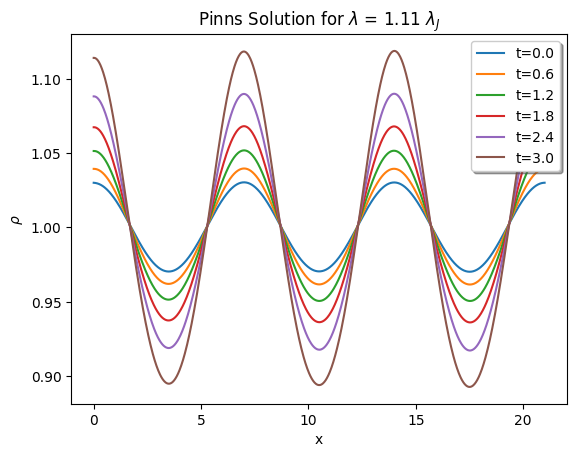

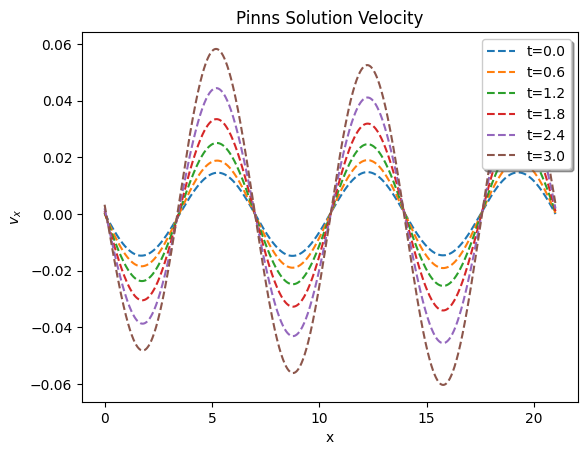

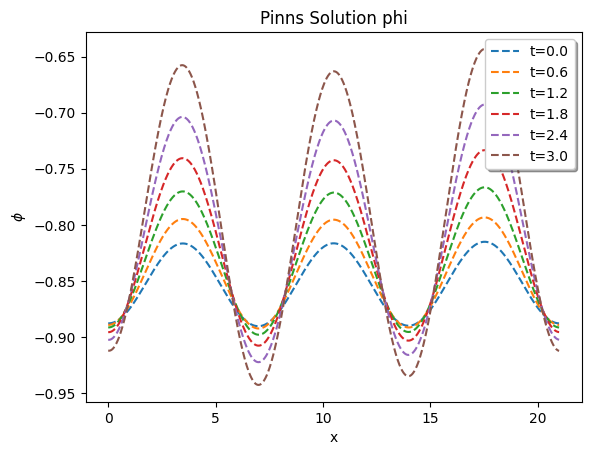

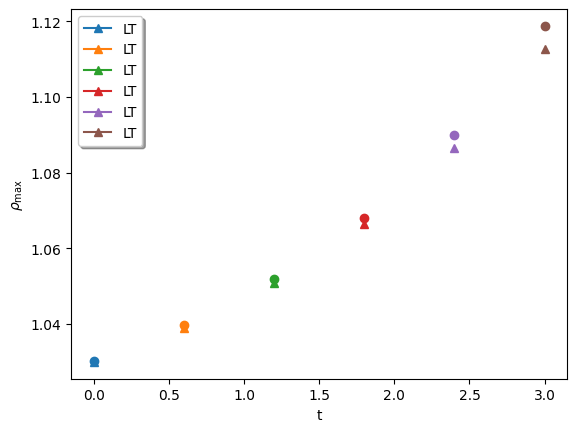

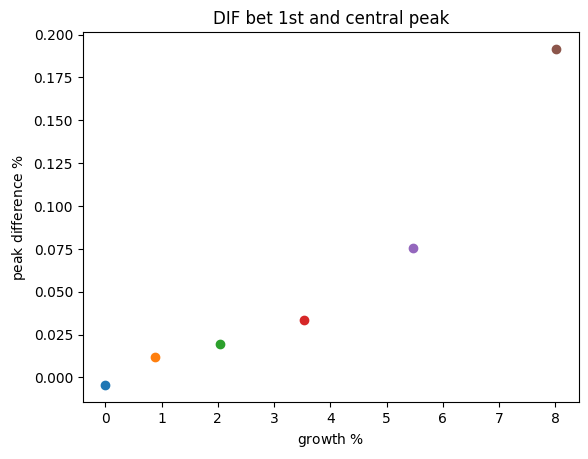

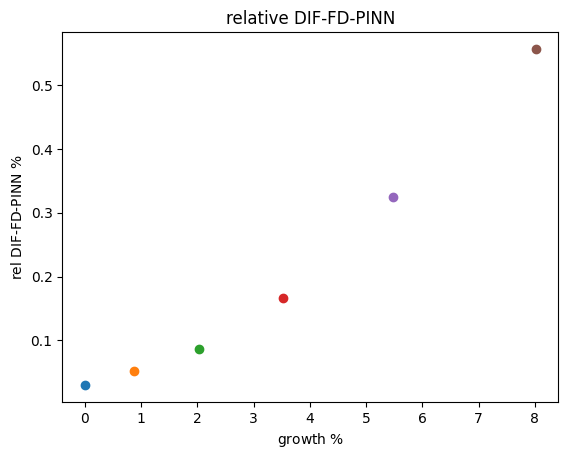

In [25]:
time_array = np.linspace(0,tmax,tmax+3)
# time_array = np.linspace(0,1,4)
plot_function(time_array,Nrez =1000,velocity=True,isplot =True)
# plot_function(time_array,velocity=True)


(125000, 3)
(125000, 1)
(50, 50, 50)


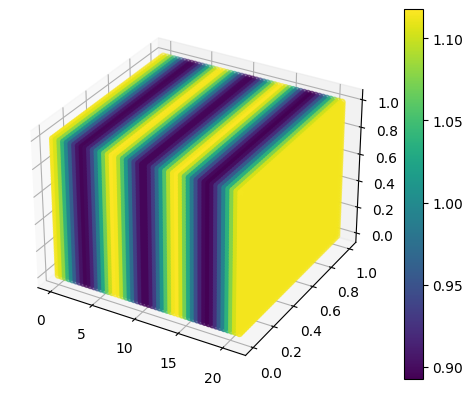

In [26]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
Q = 50
Time = 3
xs = np.linspace(0, xmax, Q)
ys = np.linspace(0, ymax, Q)
zs = np.linspace(0, zmax, Q)
xx, yy ,zz = np.meshgrid(xs, ys,zs) 
# xyz = np.vstack([xs,ys,zs])

Xgrid = np.vstack([xx.flatten(),yy.flatten(),zz.flatten()]).T
print(Xgrid.shape)
t_00 = Time*np.ones(Q**3).reshape(Q**3, 1)
print(t_00.shape)
X_00 = np.hstack((Xgrid, t_00))
np.shape(X_00)
output_00 = model.predict(X_00)
rho = output_00[:,0].reshape(Q,Q,Q)
print(rho.shape)

# # density = stats.gaussian_kde(xyz)(xyz) 

# idx = density.argsort()
# # x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xx, yy, zz, c=rho)
plt.colorbar(sc)

plt.show()

In [27]:
def Two_D_surface_plots(time,ax =None):

    Time =time
    Q = 100
    xs = np.linspace(0, xmax, Q)
    ys = np.linspace(0, ymax, Q)
    tau, phi = np.meshgrid(xs, ys) 
    Xgrid = np.vstack([tau.flatten(),phi.flatten()]).T
    t_00 = Time*np.ones(Q**2).reshape(Q**2, 1)
    Z = 0.5*np.ones(Q**2).reshape(Q**2, 1)
    X_00 = np.hstack((Xgrid, Z, t_00))
    output_00 = model.predict(X_00)
    rho = output_00[:,0].reshape(Q,Q)
    U = output_00[:,1].reshape(Q,Q)
    V = output_00[:,2].reshape(Q,Q)
#     # plt.streamplot(tau, phi, U, V, density =[0.4, 0.8], arrowstyle ='->',
#                   # arrowsize = 0.5)
#     # plt.quiver(tau, phi, U, V,color='k',headwidth=2.0,headlength=2.0) 

    if ax is None: ## for single plot
        plt.figure(figsize=(5, 5))
        ax = plt.gca() 
    # fig1, ax = plt.subplots()

    pc = ax.pcolormesh(tau, phi, rho, shading='auto',cmap='YlOrBr',vmin=np.min(rho), vmax=np.max(rho)) # YlOrBr
    # pc = ax.contourf(tau, phi, rho, shading='gouraud')
    skip = (slice(None, None, 5), slice(None, None, 5))
    ax.quiver(tau[skip], phi[skip], U[skip], V[skip],color='k',headwidth=3.0,width = 0.003)
    # ax.text(0.30, .9, r" T= {} ".format(round(time,2)), color="w", fontsize=12)
    
    ax.set_title("Time={}".format(round(time,2)))
    # plt.quiver(tau, phi, U, V,rho,color='k',headwidth=3.0,width = 0.003) 
    cbar = plt.colorbar(pc, shrink=0.6, location='bottom')
    cbar.formatter.set_powerlimits((0,0))
    cbar.ax.set_title(r" $\rho$",fontsize = 14)
    # ax.set_xlabel("x")
    # ax.set_ylabel("y",fontsize = 18)
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    
#     return pc
    # show plot
    # plt.show()
    
    # return ax
    # fig.savefig(output_folder+'/2D-Ins'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=500,bbox_inches = 'tight')

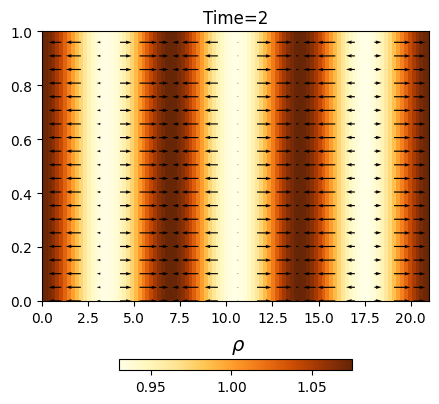

In [28]:
Two_D_surface_plots(2)

# f, [ax1,ax2,ax3] = plt.subplots(1, 3, sharex=False, sharey=True,figsize=(8,4))
# im1 = Two_D_surface_plots(0.1,ax=ax1)
# im2 = Two_D_surface_plots(2,ax=ax2)
# im2 = Two_D_surface_plots(3,ax=ax3)

In [29]:
def fft_solver(rho,Lx,N, dim = None):
    
    '''
    A FFT solver that uses discrete Fast Fourier Transform to
    solve the poisson Equation:
    We apply the correction due to the finite difference grid of phi
    
    Input: 1. The source function density in this case
           2. # of grid point N
           3. Domain Size in each dimension
    
    Output: the potential phi and the field g 
    
    '''
    nx = N
    Lx = Lx
    
    dx = Lx / nx
    
    
    # Calculate the Fourier modes of the gas density
    rhohat = fft(rho)

    # Calculate the wave numbers in x and y directions
    kx = 2 * np.pi * np.fft.fftfreq(nx, dx)
    #ky = 2 * np.pi * np.fft.fftfreq(ny, dy)

    # Construct the Laplacian operator in Fourier space
    kx2 = np.meshgrid(kx**2)
    
#     laplace = -(kx**2 )
    ## Laplace with the correction refer to the notes
    laplace = 2*(np.cos(kx*dx)-1)
    
    ## Inorder to avoid the inf we replace zero with a small number
    laplace[laplace == 0] = 1e-9
    
    # Solve for the gravitationa potential in Fourier space
    phihat = rhohat / laplace
    
    phihat = rhohat * dx**2/laplace

    phi = np.real(ifft(phihat))
    
    ## The field ,i.e., gravity 
#     dphidx = np.gradient(phi, dx)

    return phi

In [30]:
def lax_solution(time,N,nu,lam,num_of_waves,rho_1,gravity=False,isplot = None,comparison =None,animation=None):
    '''
    This function solves the hydrodynamic Eqns in 1D with/without self gravity using LAX methods 
    described above 
    
    
    Input:  Time till the system is integrated :time
            Number of Xgrid points : N
            Courant number : nu
            Wavelength : If lambda> lambdaJ (with gravity--> Instability) else waves propagation 
            Number of waves : The domain size changes and with this maintains periodicity
            Density perturbation : rho_1 (for linear or non-linear perturbation)
            Gravity:  If True it deploys the FFT routine to estimate the potential 
            isplot(optional): if True plots the outputs
            Comparison (optional) : If True then the plots are overplotted with LT solutions for comparison
            Animation (optional): Not used at the moment
    
    Output: Density, velocity + (phi and g if gravity is True)
            isplot: True then the plots are generated 
    
    '''
    
    
    # rho_max = []
    lam = lam          # one wavelength
    num_of_waves  = num_of_waves  
    L = lam * num_of_waves            # Maximum length (two wavelength)
    
    print("at time= ",time)
    ### Declaring the Constants

    c_s = 1.0            # % Sound Speed  
    rho_o = 1.0          # zeroth order density
    nu = nu              # courant number (\nu = 2 in 2d)
    rho_1 = rho_1        # for linear/nonlinear wave propagation
    const =  1           # The actual value is 4*pi
    G = 1.0              # Gravitational Constant

    ### Grid X-T 
    N = N                # The grid resolution values2d:N =(10,50,100,500)
    dx = float(L/N)      # length spacing          
    dt = nu*dx/c_s       # time grid spacing
 

    ## For simplification
    mu = dt/(2*dx)      # is the coefficient in the central differencing Eqs above 
    
    n = int(time/dt)     # grid points in time
    print("For dx = {} and dt = {} and time gridpoints n = {} ".format(dx,dt,n))
    
    ########### Initializing the ARRAY #######################
    x = np.linspace(0, L, N)
    
    rho0 = np.zeros(N)
    phi0 = np.zeros(N)
    v0 =np.zeros(N)  
    P0 =np.zeros(N) # The flux term 
    
    rho1 = np.zeros(N)
    phi1 = np.zeros(N)
    v1 =np.zeros(N)  
    P1 =np.zeros(N)
    
    ## Calculating the jeans length if gravity is Turned on
    if gravity:
        jeans = np.sqrt(4*np.pi**2*c_s**2/(const*G*rho_o))
        print("Jean's Length",jeans)

    
    ######################## Initial Conditions ###########################
    rho0 = rho_o + rho_1* np.cos(2*np.pi*x/lam) # defing the density at t = 0 EQ 11
    
    if gravity == False:
        print("Propagation of Sound wave") 
        v_1 = (c_s*rho_1)/rho_o # velocity perturbation
        v0 = v_1 * np.cos(2*np.pi*x/lam) # the velocity at t =0
        ## Linear Theory
        if comparison:
            rho_LT  = rho_o + rho_1*np.cos(2*np.pi * x/lam - 2*np.pi/lam *time)
            rho_LT_max = np.max(rho_o + rho_1*np.cos(2*np.pi * x/lam - 2*np.pi/lam *time))
            v_LT = v_1* np.cos(2*np.pi * x/lam - 2*np.pi/lam *time) 
    
    else:    ######## When self-gravity is True and see EQN 22
        if lam >= jeans:  
            print("There is gravitational instabilty  lam = {} > l_jean ={}".format(lam,jeans))
            alpha = np.sqrt(const*G*rho_o-c_s**2*(2*np.pi/lam)**2)
            v_1  = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) ## With gravity        
            v0 = - v_1 * np.sin(2*np.pi*x/lam) # the velocity at t =0
            
            ##### Density  and velocity  from Linear Theory at t 
            if comparison:
                rho_LT = rho_o + rho_1*np.exp(alpha * time)*np.cos(2*np.pi*x/lam)
                rho_LT_max = np.max(rho_o + rho_1*np.exp(alpha * time)*np.cos(2*np.pi*x/lam))
                v_LT = -v_1*np.exp(alpha * time)*np.sin(2*np.pi*x/lam)
#             print("rho_theory_max={} and the max density {} at time {}".format(rho_LT_max ,rho_max, round(time,2)))

        else:
            print("There is no gravitational instabilty as lam = {} < l_jean ={}".format(lam,jeans))
            alpha = np.sqrt(c_s**2*(2*np.pi/lam)**2 - const*G*rho_o)
            v_1 = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) # velocity perturbation
            v0 = v_1 * np.cos(2*np.pi*x/lam) # the velocity at t =0

            ##### Density  and velocity  from Linear Theory at t
            if comparison:
                rho_LT = rho_o + rho_1*np.cos(alpha * time - 2*np.pi*x/lam)
                rho_LT_max = np.max(rho_o + rho_1*np.cos(alpha * time - 2*np.pi*x/lam))
                v_LT = v_1*np.cos(alpha * time - 2*np.pi*x/lam)

        ## Calculating the potential and the field using FFT    
        phi0 = fft_solver(const*(rho0-rho_o),L,N, dim = None)

    ######### The Flux term #########
    P0=rho0*v0

    #################################FINITE DIFFERENCE #######################
    for k in range(1,n): ## Looping over time 

        rho1 = 0.5*(np.roll(rho0,-1)+ np.roll(rho0,1))-(mu*(np.roll(rho0,-1)*np.roll(v0,-1)-np.roll(rho0,1)*np.roll(v0,1)))

        if gravity == False: ## Hydro sound wave when gravity is absent 

            P1 = 0.5*(np.roll(P0,-1)+ np.roll(P0,1))-(mu*(np.roll(P0,-1)*np.roll(v0,-1)- np.roll(P0,1)*np.roll(v0,1)))-((c_s**2)*mu*(np.roll(rho0,-1)- np.roll(rho0,1)))
        else: ## With self-gravity activated 

            P1 = 0.5*(np.roll(P0,-1)+ np.roll(P0,1))-(mu*(np.roll(P0,-1)*np.roll(v0,-1)- np.roll(P0,1)*np.roll(v0,1)))\
            -((c_s**2)*mu*(np.roll(rho0,-1)- np.roll(rho0,1))) -(mu*rho0*(np.roll(phi0,-1)- np.roll(phi0,1))) #  

            phi1= fft_solver(const*(rho1-rho_o),L,N, dim = None) ## Please note we don't use dphidx rather calculate using central differencing


        ## 1-D velocity 
        v1 = P1/rho1
        
        ## updating the intial array
        rho0 = rho1
        v0 = v1
        P0 = P1
        phi0= phi1
        
        ## updating the dt for numerical stability
        dt1 = nu*dx/np.max(abs(v1))
        dt2 = nu*dx/c_s        
        dt = np.min([dt1,dt2])
        mu = dt/(2*dx)     
        n = int(time/dt)     # grid points in time

    
    
    rho_max = np.max(rho1)   ## Maximum density from the FD calculation 
    
    
    ################################# PLOTTING #######################
 
    if isplot : 
        plt.figure(1,figsize=(6,4))
        plt.plot(x,rho1-rho_o,linewidth=1,label="FD at t={}".format(round(time,2)))
        plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
        plt.xlabel(r"$\mathbf{x}$")
        # plt.text(.6,.15,r"dt=%f"%(dt),fontsize=12)
        plt.title("At time {} and rho_1 = {}".format(time,rho_1))
        plt.ylabel(r"$\mathbf{\rho - \rho_{0}}$")
        if comparison : 
            plt.plot(x,rho_LT-rho_o,'--',linewidth=1,label="LT")
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)

        plt.figure(2,figsize=(6,4))
        plt.plot(x,v1,'--',markersize=2,label="t={}".format(round(time,2)))
        plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
        plt.xlabel(r"$\mathbf{x}$")
        plt.title(r"Lax Solution Velocity For $\rho_1$ = {}".format(rho_1))
        plt.ylabel("velocity")
        if comparison : 
            plt.plot(x,v_LT,'--',linewidth=1,label="LT")
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)    

        if gravity:
             #### Plotting the comparison of the \rho_max for FD and Linear Theory 
            
            plt.figure(3,figsize=(6,4))                                
            plt.scatter(time,rho_max,label="LT")                     
            plt.xlabel("t")
            plt.ylabel(r"$\log (\rho_{\rm max} - \rho_{0}) $")
            plt.yscale('log')            
            if comparison : 
                plt.scatter(time,rho_LT_max,facecolors='none', edgecolors='r',label="LT") 
                plt.legend(numpoints=1,loc='upper left',fancybox=True,shadow=True)

            ## Plotting the gravitational potential (\phi) and field (g)
            plt.figure(4,figsize=(6,4))
            plt.plot(x,phi1,'--',markersize=2,label="t=phi at {}".format(round(time,2)))
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.xlabel(r"$\mathbf{x}$")
            plt.title(r"Lax Solution Phi For $\rho_1$ = {}".format(rho_1))
            plt.ylabel(r"$\Phi$")

    else:
        if gravity:
            if comparison:
                return x,rho1,v1,phi1,n,rho_LT,rho_LT_max,rho_max,v_LT
            else:
                return x,rho1,v1,phi1,n,rho_max
        else:
            if comparison:
                return rho1,v1,rho_LT,rho_LT_max,rho_max,v_LT
            else:
                return x,rho1,v1,n,rho_max
            
    ## Clearing the memory
    del rho0, phi0, v0, P0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

at time=  0.5
For dx = 0.021 and dt = 0.0105 and time gridpoints n = 47 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
Plotting at t= 0.5
at time=  1.5
For dx = 0.021 and dt = 0.0105 and time gridpoints n = 142 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
Plotting at t= 1.5
at time=  2.5
For dx = 0.021 and dt = 0.0105 and time gridpoints n = 238 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
Plotting at t= 2.5


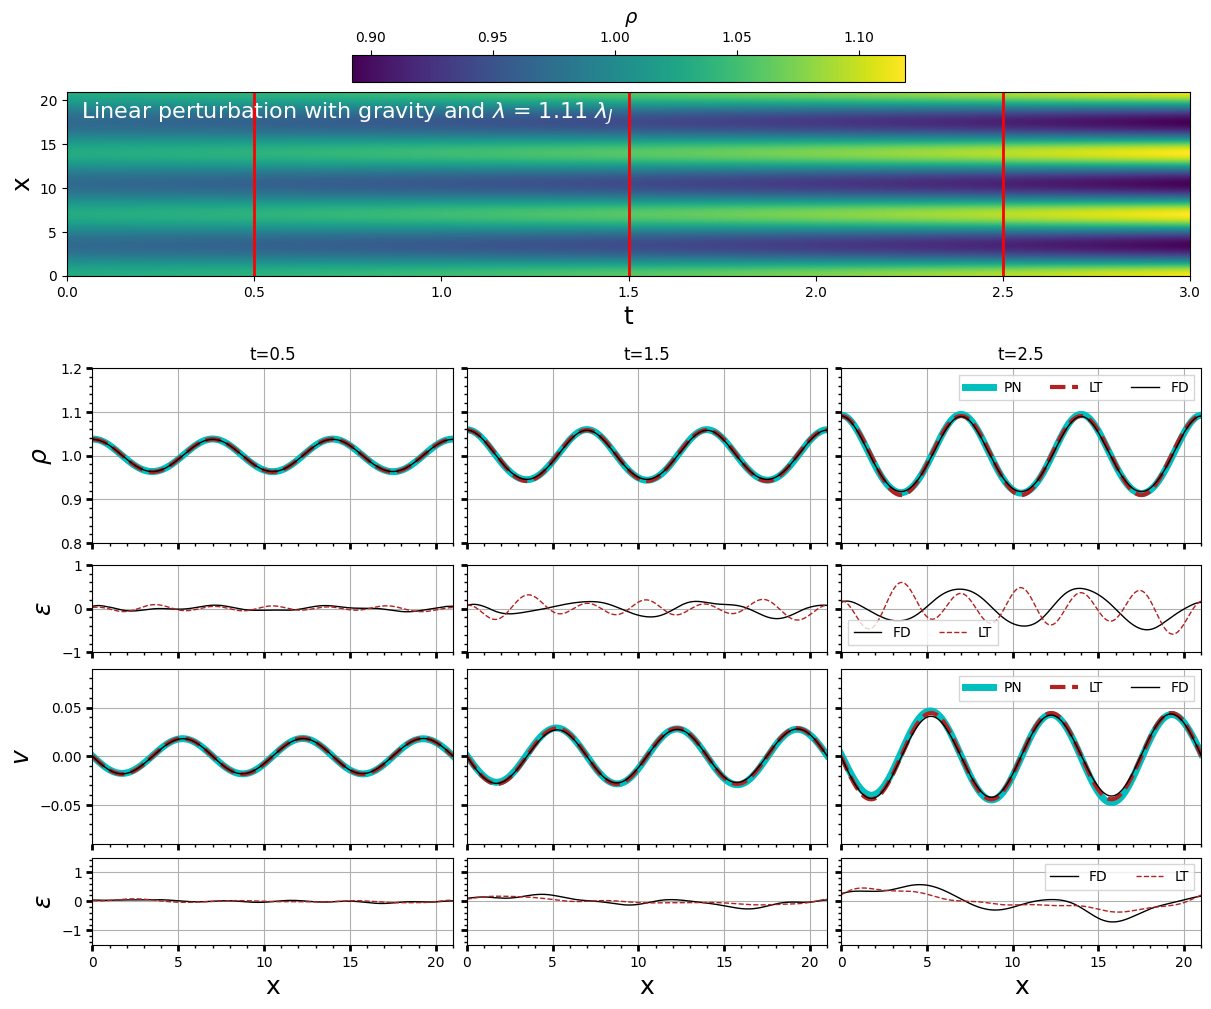

In [31]:
time_array = np.asarray([0.5,1.5,2.5])
plt.style.use('default')
def example_plot(ax, fontsize=18, hide_labels=False):
    Q=1000  ## Resolution of the 1D contour plot
    X, T = np.meshgrid(np.linspace(xmin,xmax,Q), np.linspace(0,tmax,Q))
    y_slice = ycut*np.ones(Q**2).reshape(Q**2, 1)
    z_slice = ycut*np.ones(Q**2).reshape(Q**2, 1)
    X_star = np.hstack((X.flatten()[:,None],y_slice.flatten()[:,None],z_slice.flatten()[:,None], T.flatten()[:,None]))
    
    output_0 = model.predict(X_star)
    rho_pred0 = output_0[:,0:1]
    Z = rho_pred0.reshape(Q,Q)
    pc = ax.pcolormesh(T,X,Z, shading='auto')
    
    if not hide_labels:
        ax.set_xlabel('t', fontsize=fontsize)
        ax.set_ylabel('x', fontsize=fontsize)
        ax.set_title('', fontsize=fontsize)
    return pc

## Number of grid points and courant conditions for the LAX method
N  = 1000
nu = 0.5

np.random.seed(19680808)
# gridspec inside gridspec
fig = plt.figure(layout='constrained',figsize=(12, 10))
subfigs = fig.subfigures(2, 1, height_ratios=[1.5,3])

axsLeft = subfigs[0].subplots(1, 1, sharey=False)
axsLeft.set_ylim(xmin,xmax)
axsLeft.set_xlim(0,tmax)
# subfigs[0].set_facecolor('0.75')
pc = example_plot(axsLeft)
# subfigs[0].suptitle('Left plots', fontsize='x-large')
axsLeft.text(0.038, 18, r"Linear perturbation with gravity and $\lambda$ = {} $\lambda_J $ ".format(round(lam/(2*np.pi),2)), color="w", fontsize=16)
cbar = subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='top')
cbar.formatter.set_powerlimits((0,0))
cbar.ax.set_title(r" $\rho$",fontsize = 14)

axes = subfigs[1].subplots(4, 3,sharex=True,  sharey='row',gridspec_kw={'width_ratios':[1,1,1], 'height_ratios':[3,1.5,3,1.5]})
for time,j in zip(time_array,(range(len(axes[0])))):
    x,rho,v,phi,n, rho_LT,rho_LT_max,rho_max_FD,v_LT= lax_solution(time,N,nu,lam,num_of_wave,rho_1,gravity=True,isplot = False,comparison =True,animation=True)
    X,rho_pred0,v_pred0,phi_pred0,rho_max_PN,rho_theory = plot_function(time,Nrez = N,velocity=True,isplot = False, animation=True)
    axsLeft.axvline(x=time, linewidth=2,color='r')
    axes[0][j].plot(X,rho_pred0,color='c',linewidth=5,label="PN")    
    axes[0][j].plot(X,rho_LT,linestyle='dashed',color ='firebrick',linewidth=3,label="LT")
    axes[0][j].plot(x,rho,linestyle='solid',color = 'black',linewidth=1.0,label="FD")
    axes[0][j].set_xlim(xmin,xmax)
    
    axes[0][j].set_title("t={}".format(round(time,2)))
    axes[0][0].set_ylabel(r"$\rho$",fontsize = 18)
    # axes[0][j].set_xlabel("x",fontsize = 18)
    axes[0][j].grid("True")
    axes[0][j].minorticks_on()
    axes[0][j].tick_params(labelsize=10)
    axes[0][j].tick_params(axis='both', which='major',length=4, width=2)
    axes[0][j].tick_params(axis='both', which='minor',length=2, width=1)
    limu = 1.2*rho_o
    liml = .8*rho_o
    axes[0][j].set_ylim(liml,limu)
    axes[0][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 10)
    # axes[1][0].text(0.38, 0.82, r"$\rho_1$ = {}, $\lambda$ = {} $\lambda_J$ ".format(rho_1,round(lam/(2*np.pi),2)),fontsize = 15, horizontalalignment='center', verticalalignment='center', transform=axes[0][0].transAxes) 

    
    axes[1][j].plot(x,(rho_pred0[:,0]- rho)/((rho_pred0[:,0]+ rho)/2)*100,color = 'black',linewidth=1,label="FD")
    axes[1][j].plot(x,(rho_pred0.flatten()-rho_LT.flatten())/((rho_pred0.flatten()+ rho_LT.flatten())/2)*100,color = 'firebrick',linestyle='dashed',linewidth=1,label="LT")
    # axes[1][j].plot(x,(rho_pred0[:,0]- rho[n-1,:])/((rho_pred0[:,0]+ rho[n-1,:])/2)*100,color = 'k',linewidth=1,label="FD")
    # axes[1][j].plot(x,(rho_pred0[:,0]-rho_LT)/((rho_pred0[:,0]+ rho_LT)/2)*100,color = 'b',linewidth=1,label="LT")
    # axes[2][j].set_xlabel("x",fontsize = 18)
    axes[1][j].grid("True")
    axes[1][j].minorticks_on()
    axes[1][j].tick_params(labelsize=10)
    axes[1][j].tick_params(axis='both', which='major',length=4, width=2)
    axes[1][j].tick_params(axis='both', which='minor',length=2, width=1.)
    axes[1][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 10)
    # axes[1][0].set_ylabel(r"$\rho_{PN}- \rho_{FD or LT}/(0.5 (\times\rho_{PN}+ \rho_{FD or LT}))$",fontsize = 10)
    axes[1][j].set_ylim(-1.0,1.0)
    axes[1][j].set_xlim(xmin,xmax)
    axes[1][0].set_ylabel(r"$\epsilon$",fontsize = 18)
    
    
     ### VELOCITY PART ######
   
    axes[2][j].plot(X,v_pred0,color='c',linewidth=5,label="PN")    
    axes[2][j].plot(X,v_LT,linestyle='dashed',color ='firebrick',linewidth=3,label="LT")
    axes[2][j].plot(x,v,linestyle='solid',color = 'black',linewidth=1.0,label="FD")
    
    
    # axes[3][j].set_title("Time={}".format(round(time,2)))
    axes[2][0].set_ylabel(r"$v$",fontsize = 18)
    # axes[0][j].set_xlabel("x",fontsize = 18)
    axes[2][j].grid("True")
    axes[2][j].minorticks_on()
    axes[2][j].tick_params(labelsize=10)
    axes[2][j].tick_params(axis='both', which='major',length=4, width=2)
    axes[2][j].tick_params(axis='both', which='minor',length=2, width=1)
    # limu = 1.15*v_o
    # liml = .85*v_o
    # axes[0][j].set_ylim(liml,limu)
    axes[2][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 10)
    # axes[2][0].text(0.44, 0.9, r"$\rho_1$ = {}, $\lambda$ = {} $\lambda_J$ ".format(rho_1,round(lam/(2*np.pi),2)),fontsize = 15, horizontalalignment='center', verticalalignment='center', transform=axes[0][0].transAxes)
    axes[2][j].set_xlim(xmin,xmax)
    axes[2][j].set_ylim(-0.09,0.09)
    
    
    axes[3][j].plot(x,(v_pred0[:,0]+1- (v+1))/((v_pred0[:,0]+1+ v+1)/2)*100,color = 'black',linewidth=1,label="FD")
    axes[3][j].plot(x,(v_pred0.flatten()+1-(v_LT.flatten()+1))/((v_pred0.flatten()+2+ v_LT.flatten())/2)*100,color = 'firebrick',linestyle='dashed',linewidth=1,label="LT")
    # axes[1][j].plot(x,(rho_pred0[:,0]- rho[n-1,:])/((rho_pred0[:,0]+ rho[n-1,:])/2)*100,color = 'k',linewidth=1,label="FD")
    # axes[1][j].plot(x,(rho_pred0[:,0]-rho_LT)/((rho_pred0[:,0]+ rho_LT)/2)*100,color = 'b',linewidth=1,label="LT")
    axes[3][j].set_xlabel("x",fontsize = 18)
    axes[3][j].grid("True")
    axes[3][j].minorticks_on()
    axes[3][j].tick_params(labelsize=10)
    axes[3][j].tick_params(axis='both', which='major',length=4, width=2)
    axes[3][j].tick_params(axis='both', which='minor',length=2, width=1.)
    axes[3][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 10)
    # axes[1][0].set_ylabel(r"$\rho_{PN}- \rho_{FD or LT}/(0.5 (\times\rho_{PN}+ \rho_{FD or LT}))$",fontsize = 10)
    axes[3][0].set_ylabel(r"$\epsilon$ ",fontsize = 18)
    axes[3][j].set_ylim(-1.5,1.5)
    axes[3][j].set_xlim(xmin,xmax)
    
    
    
plt.savefig(output_folder+'/complete'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=500,bbox_inches = 'tight')

## Growth Plots

at time=  0.1
For dx = 0.021 and dt = 0.0105 and time gridpoints n = 9 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
Plotting at t= 0.1
[]
at time=  1.0666666666666667
For dx = 0.021 and dt = 0.0105 and time gridpoints n = 101 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
Plotting at t= 1.0666666666666667
[0.031122800573880616]
at time=  2.033333333333333
For dx = 0.021 and dt = 0.0105 and time gridpoints n = 193 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
Plotting at t= 2.033333333333333
[0.031122800573880616, 0.047947713385095625]
at time=  3.0
For dx = 0.021 and dt = 0.0105 and time gridpoints n = 285 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
Plotting at t= 3.0
[0.031122800573880616, 0.047947713385095625, 0.07363717657469704]
[0.031122800573

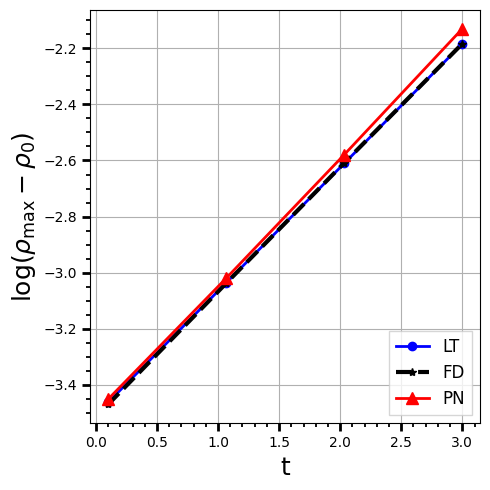

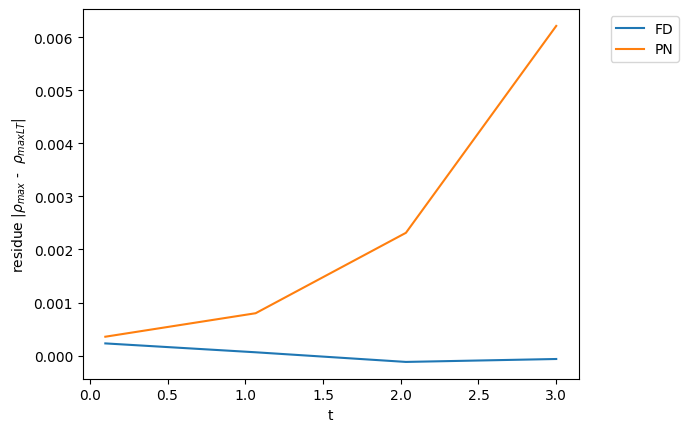

In [32]:
time_array = np.linspace(0.1,tmax,4)
plt.style.use('default')
Growth_LT_list = []
Growth_FD_list = []
Growth_PN_list = []
for time in time_array:
    x,rho,v,phi,n, rho_LT,rho_LT_max,rho_max_FD,v_LT= lax_solution(time,N,nu,lam,num_of_wave,rho_1,gravity=True,isplot = False,comparison =True,animation=True)
    X,rho_pred0,v_pred0,phi_pred0,rho_max_PN,rho_theory = plot_function(time,Nrez = N,velocity=True,isplot = False, animation=True)
    Growth_LT = rho_LT_max - rho_o
    Growth_FD = rho_max_FD - rho_o  
    Growth_PN = rho_max_PN - rho_o
    Growth_LT_list.append(Growth_LT)
    print(Growth_FD_list)
    Growth_FD_list.append(Growth_FD)
    Growth_PN_list.append(Growth_PN)
print(Growth_FD_list)
plt.figure(2,figsize=(5,5))
plt.plot(time_array,np.log(Growth_LT_list),marker='o', color='b',linewidth=2,label= "LT")
plt.plot(time_array,np.log(Growth_FD_list),'--',marker='*',color='k',linewidth=3,label= "FD")
plt.plot(time_array, np.log(Growth_PN_list),marker='^',markersize=8,linewidth=2,color = 'r',label="PN") 
plt.xlabel("t",fontsize = 18)
plt.ylabel(r"$\log (\rho_{\rm max} - \rho_{0}) $",fontsize = 18)
plt.grid("True")
# plt.yscale('log')
# plt.ylim(np.min(np.log(Growth_LT_list)),np.max(np.log(Growth_LT_list)))
# plt.text(0.40, np.log(3), r"$\rho_1$ = {}, $\lambda$ = {} $\lambda_J$ ".format(rho_1,round(lam/(2*np.pi),2)),fontsize = 14, horizontalalignment='center', verticalalignment='center')
plt.minorticks_on()
plt.tick_params(labelsize=10)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.legend(loc='lower right',fancybox=False, shadow=False, ncol=1,fontsize = 12)
plt.tight_layout()
# plt.legend()
plt.savefig(output_folder+'/log-PINN-FD-Comp'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png',  dpi=500)

# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.figure(3)
diff_FD = (np.array(Growth_LT_list) - np.array(Growth_FD_list))
diff_PN = (np.array(Growth_LT_list) - np.array(Growth_PN_list))
# diff_FD = (np.array(Growth_LT_list) - np.array(Growth_PN_list))
plt.plot(time_array,np.array(diff_FD),label="FD")
plt.plot(time_array,np.abs(diff_PN),label="PN")
plt.ylabel(r"residue |$\rho_{max}$ -  $\rho_{max LT}|$")
plt.xlabel("t")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(output_folder+'/DIFF-PINN-FD-Comp'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)

## Animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as anim
from IPython.display import HTML
from pathlib import Path

from matplotlib import animation, rc
from IPython.display import HTML, Image # For GIF

rc('animation', html='html5')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# import matplotlib.animation as animation
import matplotlib.animation as anim
# plt.style.use('ggplot')
plt.style.use('default')

## Time and Space Array
t = np.linspace(0,tmax,100)
Q = 50
Time = 3
xs = np.linspace(0, xmax, Q)
ys = np.linspace(0, ymax, Q)
zs = np.linspace(0, zmax, Q)
xx, yy ,zz = np.meshgrid(xs, ys,zs) 
numDataPoints = len(t)

Xgrid = np.vstack([xx.flatten(),yy.flatten(),zz.flatten()]).T
print(Xgrid.shape)

def animate_func(num):
    fig.clear()
    # ax.clear()  # Clears the figure to update the line, point,   
    # ax2.clear()  
    # ax3.clear()  # Clears the figure to update the line, point
    # ax4.clear()  # Clears the figure to update the line, point
    
    t_ = t[num+1]*np.ones(Q**3).reshape(Q**3, 1)
    # t_00 = Time*np.ones(Q**3).reshape(Q**3, 1)
    X_00 = np.hstack((Xgrid, t_))
    np.shape(X_00)
    output_00 = model.predict(X_00)
    rho = output_00[:,0].reshape(Q,Q,Q)
    # v_pred0 = output_0[:, 1:2]
    # phi_pred0=output_0[:, 2:3]

    ax = fig.add_subplot(111, projection='3d')
    # ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(xx, yy, zz, c=rho)
    plt.colorbar(sc)
    # ax.axes.set_zlim3d(bottom=0.85, top=1.20)
    # surf = ax.plot_surface(tau, phi, rho_pred0 , cmap='viridis')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("$z$",labelpad=1)
    ax.set_title("Time={}".format(round(t[num+1],2)))
    # fig.colorbar(surf, shrink=0.5, aspect=5)

    # plt.title(r"Pinns Solution for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)))
    plt.tight_layout()



line_ani = FuncAnimation(fig, animate_func, interval=30,   
                                   frames=numDataPoints-1)
# # converting to an html5 video
# video = line_ani.to_html5_video()
  
# # embedding for the video
# html = display.HTML(video)
  
# # draw the animation
# display.display(html)
# saving to m4 using ffmpeg writer
# writervideo = animation.FFMpegWriter(fps=20)
# line_ani.save('3Dinstability_'+str(lam)+ '.mp4', writer=writervideo)
# ax4.clear()  # Clears the figure to update the line, point
line_ani.save(output_folder+'/3Dinstability_'+str(lam)+ '.gif', writer='pillow', fps=60)
plt.close()
plt.show()
